In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from GSSL import GSSLTransductive, GSSLInductive
from GSSL import gbili, rgcli

from ucimlrepo import fetch_ucirepo

np.random.seed(42)

 # GBILI

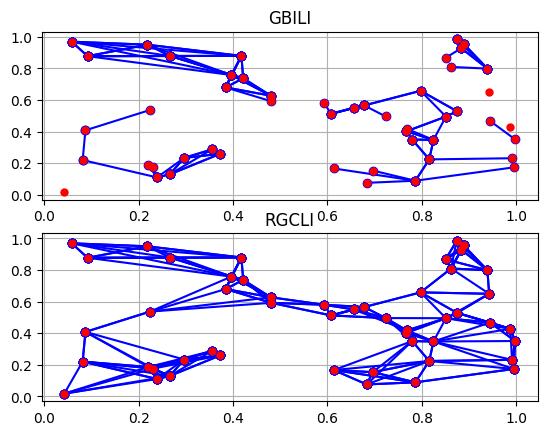

In [9]:
X = np.random.rand(50, 2)
y = np.random.choice([-1, 0, 1], size=50, p=[0.7, 0.15, 0.15])

W = gbili(X, y, 5)
W2 = rgcli(X, y, 5, 5, 5)

fig, ax = plt.subplots(2, 1)

for a, b in W.keys():
    ax[0].plot([X[a, 0], X[b, 0]], [X[a, 1], X[b, 1]], 'bo-')

ax[0].plot(X[:, 0], X[:, 1], 'ro', markersize=5)
ax[0].set_title('GBILI')
ax[0].grid(True)

for a, b in W2.keys():
    ax[1].plot([X[a, 0], X[b, 0]], [X[a, 1], X[b, 1]], 'bo-')

ax[1].plot(X[:, 0], X[:, 1], 'ro', markersize=5)
ax[1].set_title('RGCLI')
ax[1].grid(True)

plt.show()

In [39]:
fetch = fetch_ucirepo(id=186)

# Experimentación GSSL

- Intentar estimar unos parámetros aceptables para RGCLI (en GBILI el propio paper ya los dice).
- Extraer resultados individuales de RGCLI vs GBILI.
- Extraer resultados comparativa RGCLI, KNN, ST.
- Extraer resultados comparativa GBILI, KNN, ST.
- Observar la inlfuencia de quitar los no etiquetados de Train.

# Transductivo

In [2]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd


def encontrar_fila_con_palabra(ruta_archivo, palabra):
    with open(ruta_archivo, 'r') as archivo:
        for num_linea, linea in enumerate(archivo, 1):
            if palabra in linea:
                return num_linea
    return -1


def cross_val(name, p_unlabeled):
    accuracy_gssl = []
    accuracy_knn = []
    accuracy_st = []

    print("PERCENTAGE:", p_unlabeled, "- DATASET:", name)
    for k in range(1, 11):
        train_data = pd.read_csv(
            f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tra.dat',
            header=None,
            skiprows=encontrar_fila_con_palabra(
                f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tra.dat',
                '@data'))

        test_data = pd.read_csv(
            f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tst.dat',
            header=None,
            skiprows=encontrar_fila_con_palabra(
                f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tst.dat',
                '@data'))

        columnas_strings = train_data.iloc[:, :-1].select_dtypes(exclude=['number']).columns.tolist()

        for col in columnas_strings:
            encoder = LabelEncoder()
            train_data.iloc[:, col] = encoder.fit_transform(train_data.iloc[:, col])
            train_data[col] = train_data[col].apply(pd.to_numeric)
            test_data.iloc[:, col] = encoder.transform(test_data.iloc[:, col])
            test_data[col] = test_data[col].apply(pd.to_numeric)

        if pd.api.types.is_numeric_dtype(test_data.iloc[:, -1]):
            train_data.loc[train_data.iloc[:, -1] == ' unlabeled', len(train_data.columns) - 1] = -1
            train_data.iloc[:, -1] = pd.to_numeric(train_data.iloc[:, -1])
        else:
            label_encoder = LabelEncoder()
            # Codificar las etiquetas de clase
            train_data.iloc[:, -1] = label_encoder.fit_transform(train_data.iloc[:, -1])
            train_data.loc[train_data.iloc[:, -1] == label_encoder.transform([' unlabeled'])[0], len(
                train_data.columns) - 1] = -1

            test_data.iloc[:, -1] = label_encoder.transform(test_data.iloc[:, -1])

        train_data[train_data.columns[-1]] = train_data[train_data.columns[-1]].astype(int)
        test_data[test_data.columns[-1]] = test_data[test_data.columns[-1]].astype(int)

        train_data_label = train_data[train_data.iloc[:, -1] != -1]

        gssl = GSSLTransductive()
        # print(my_tree.export_tree())
        # print(accuracy_score(test_data.iloc[:, -1].values, my_tree.predict(test_data.iloc[:, :-1].values)))

        knn = KNeighborsClassifier()
        knn.fit(train_data_label.iloc[:, :-1].values, train_data_label.iloc[:, -1].values)
        # print(export_text(dt))
        # print(accuracy_score(test_data.iloc[:, -1].values, dt.predict(test_data.iloc[:, :-1].values)))
        self_training_model = SelfTrainingClassifier(KNeighborsClassifier())
        self_training_model.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values)

        accuracy_gssl.append(
            accuracy_score(test_data.iloc[:, -1].values, gssl.fit_predict(
                np.concatenate((train_data.iloc[:, :-1].values, test_data.iloc[:, :-1].values), axis=0)
                , np.concatenate((train_data.iloc[:, -1].values, [-1] * len(test_data.iloc[:, -1].values)))
            )[len(train_data):]
                           ) # Probar a quitar los no etiquetados de train y concatenar despues las de test
        )
        accuracy_knn.append(accuracy_score(test_data.iloc[:, -1].values, knn.predict(test_data.iloc[:, :-1].values)))
        accuracy_st.append(accuracy_score(test_data.iloc[:, -1].values,
                                          self_training_model.predict(test_data.iloc[:, :-1].values)))

        print("\tFOLD", k, "- Done")

    return np.median(accuracy_gssl), np.median(accuracy_knn), np.median(accuracy_st)

In [3]:
names = [
    # "abalone",
    "appendicitis",
    "australian",
    # "automobile",
    # "banana", best_left (puede ser porque tiene -1 en las etiquetas)
    # "breast",
    "bupa",
    # "chess",
    "cleveland",
    #"coil2000", tarda
    "contraceptive",
    # crx",
    "dermatology",
    "ecoli",
    "flare",
    "german",
    "glass",
    "haberman",
    "heart",
    "hepatitis",
    # "housevotes",
    "iris",
    "led7digit",
    # "lymphography",
    # "magic", tarda mucho
    "mammographic",
    #"marketing", tarda
    "monk-2",
    "movement_libras",
    # "mushroom",
    #"nursery", tarda
    #"page-blocks", tarda
    #"penbased", tarda
    #"phoneme", tarda
    # "pima",
    # "ring", no hay problema, pero tarda como dos milenios (aprox)
    "saheart",
    #"satimage", tarda
    "segment",
    "sonar",
    #"spambase", tarda
    "spectfheart",
    #"splice", problemas
    "tae",
    # "texture", no hay problema, pero tarda como tres milenios (aprox)
    # "thyroid", tarda
    "tic-tac-toe",
    # "titanic", tiene -1 en las etiquetas
    # "twonorm", tarda
    "vehicle",
    "vowel",
    "wine",
    "wisconsin",
    "yeast",
    "zoo"
]

In [4]:
from scipy.stats import rankdata

all_medians = {}

all_mean_rankings = np.empty((3, 4))

for i, p in enumerate(["10", "20", "30", "40"]):
    medians_gssl = []
    medians_knn = []
    medians_st = []
    for name in names:
        m_ssl, m_dt, m_st = cross_val(name, p)
        # break
        medians_gssl.append(m_ssl)
        medians_knn.append(m_dt)
        medians_st.append(m_st)
    # break
    print(medians_gssl)
    print(medians_knn)
    print(medians_st)
    
    all_medians[p] = np.stack((medians_gssl, medians_knn, medians_st))

    rankings = rankdata(-all_medians[p], method="average", axis=0)
    print(rankings)

    all_mean_rankings[:, i] = np.mean(rankings, axis=1)

final_rankings = rankdata(all_mean_rankings, method="average", axis=0)
print(all_mean_rankings)

PERCENTAGE: 10 - DATASET: appendicitis
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: australian
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: bupa
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: cleveland
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: contraceptive
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: dermatology
	FOLD 1 - Done
	FOLD 2 -

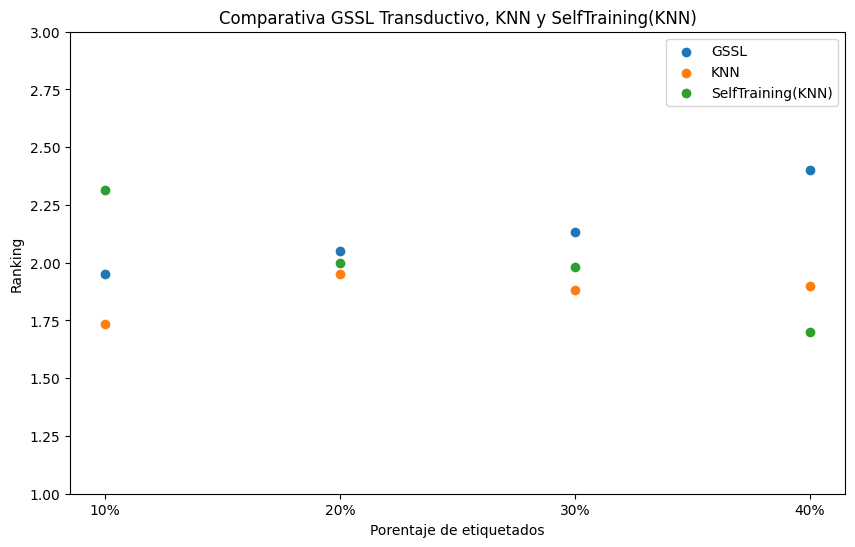

In [5]:
plt.figure(figsize=(10, 6))

for i, percentage in enumerate(["10%", "20%", "30%", "40%"]):
    top = all_mean_rankings[:, i].copy()
    uniques, _ = np.unique(top, return_counts=True)

classifiers = ["GSSL", "KNN", "SelfTraining(KNN)"]
for j, classifier in enumerate(classifiers):
    plt.scatter(["10%", "20%", "30%", "40%"], all_mean_rankings[j], label=classifier)

plt.ylim(1, 3)
plt.xlabel("Porentaje de etiquetados")
plt.ylabel("Ranking")
plt.title("Comparativa GSSL Transductivo, KNN y SelfTraining(KNN)")

plt.legend()
plt.show()

# Inductivo

In [37]:
dataset = fetch.data.features.values
real_targets = np.ravel(fetch.data.targets)
labels = np.copy(real_targets)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)

num_samples_to_unlabel = int(0.7 * len(y_train))
unlabeled_indices = np.random.choice(len(y_train), num_samples_to_unlabel, replace=False)
y_train[unlabeled_indices] = -1

no_labeled = np.where(y_train == -1)[0]
labeled = np.where(y_train != -1)[0]

X_train_labeled = X_train[labeled, :]
y_train_labeled = y_train[labeled]

X_train_no_labeled = X_train[no_labeled, :]
y_train_no_labeled = y_train[no_labeled]

X = np.concatenate((X_train_labeled, X_train_no_labeled))
y = np.hstack((y_train_labeled, y_train_no_labeled))

trans = GSSLInductive()

trans.fit(X, y)

pred = trans.predict(X_test)

print("Accuracy GSSL:", accuracy_score(y_test, pred))
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_labeled, y_train_labeled)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))

Accuracy GSSL: 1.0
Accuracy KNN: 1.0
